<a href="https://colab.research.google.com/github/CengARY/JPN/blob/main/Siamese1try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
from PIL import Image

In [ ]:
# Google Drive'ı bağlayın
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

In [ ]:
class Config():
    training_dir = "/content/drive/MyDrive/sign_data/train"
    testing_dir = "/content/drive/MyDrive/sign_data/test"
    train_batch_size = 16
    train_number_epochs = 20

In [ ]:
training_dir = "/content/drive/MyDrive/sign_data/train"
training_csv = "/content/drive/MyDrive/sign_data/train_data.csv"
testing_csv = "/content/drive/MyDrive/sign_data/test_data.csv"
testing_dir = "/content/drive/MyDrive/sign_data/test"

class SiameseNetworkDataset():

    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.training_df = pd.read_csv(training_csv, sep=';')
        self.training_df.columns = ["image1", "image2", "label"]
        self.training_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):

        # getting the image path
        image1_path = os.path.join(self.training_dir, self.training_df.iat[index, 0])
        image2_path = os.path.join(self.training_dir, self.training_df.iat[index, 1])

        # Loading the image
        img1 = Image.open(image1_path)
        img2 = Image.open(image2_path)

        img1 = img1.convert("L")
        img2 = img2.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.from_numpy(np.array([int(self.training_df.iat[index, 2])], dtype=np.float32))

    def __len__(self):
        return len(self.training_df)



In [ ]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(training_csv, training_dir,
                                        transform=transforms.Compose([transforms.Resize((105, 105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

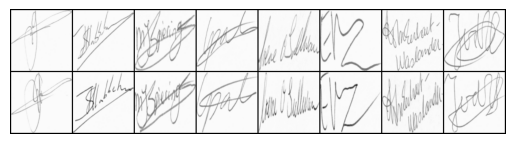

[[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [ ]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(

            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128,2))



    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

Yes


In [ ]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)

In [ ]:
def train():
    counter = []
    loss_history = []
    iteration_number= 0

    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch number 0
 Current loss 2.241659641265869

Epoch number 0
 Current loss 1.437603235244751

Epoch number 0
 Current loss 0.9245366454124451

Epoch number 0
 Current loss 1.187179684638977

Epoch number 0
 Current loss 1.6562342643737793

Epoch number 0
 Current loss 1.2377233505249023

Epoch number 0
 Current loss 1.719675064086914

Epoch number 0
 Current loss 1.4789854288101196

Epoch number 0
 Current loss 1.846547245979309

Epoch number 0
 Current loss 1.2225619554519653

Epoch number 0
 Current loss 1.2732632160186768

Epoch number 0
 Current loss 0.9256490468978882

Epoch number 0
 Current loss 1.3677117824554443

Epoch number 0
 Current loss 0.9058630466461182

Epoch number 0
 Current loss 1.457622766494751

Epoch number 0
 Current loss 1.477601408958435

Epoch number 0
 Current loss 0.7319632768630981

Epoch number 0
 Current loss 1.2483808994293213

Epoch number 0
 Current loss 1.2851805686950684

Epoch number 0
 Current loss 1.3606188297271729

Epoch number 0
 Current los

In [ ]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt"))


test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


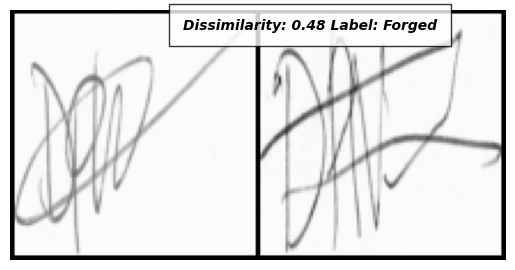

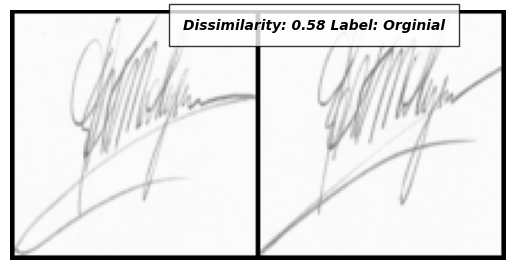

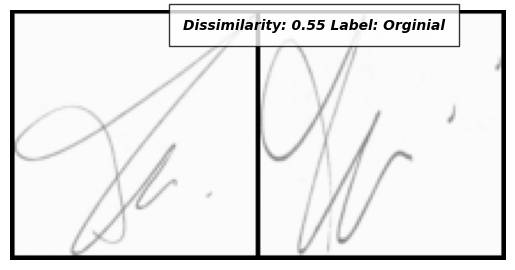

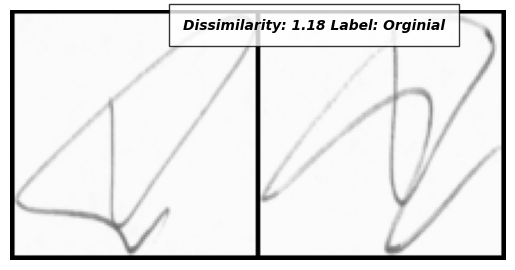

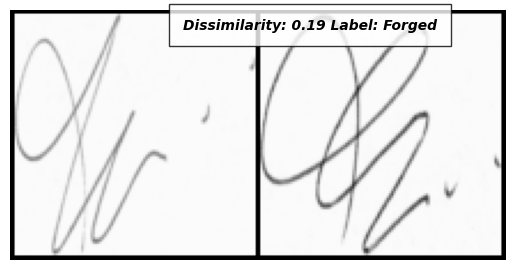

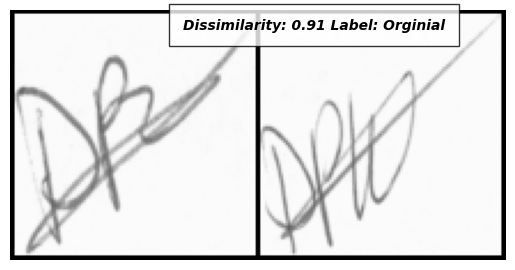

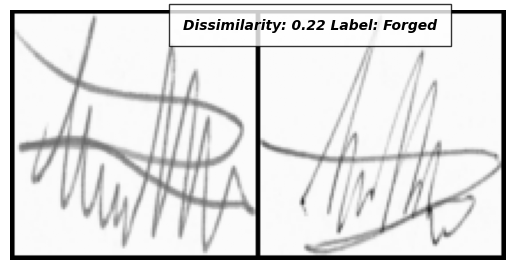

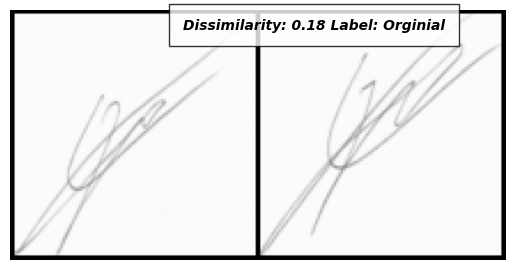

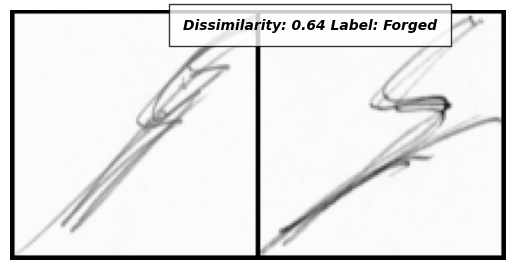

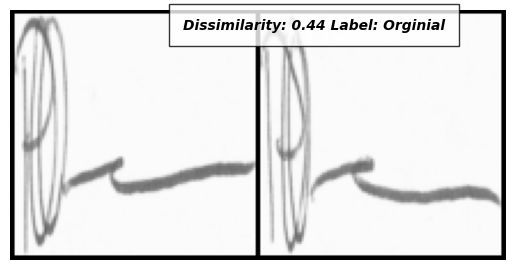

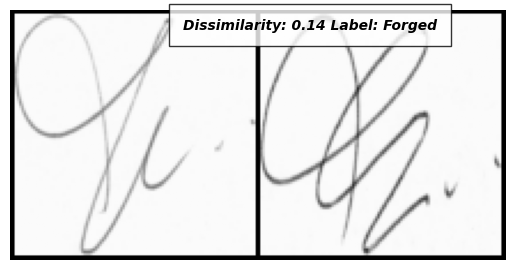

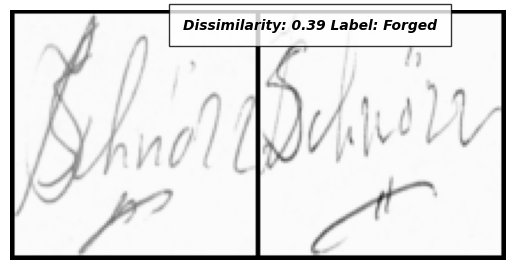

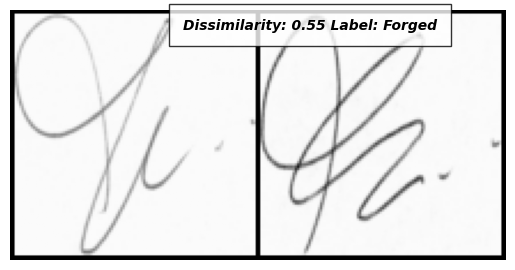

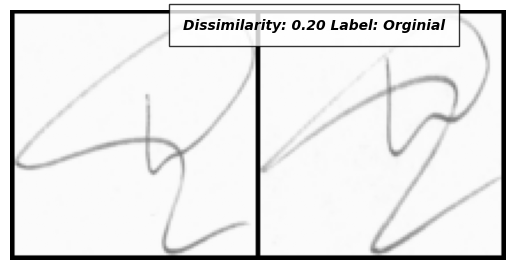

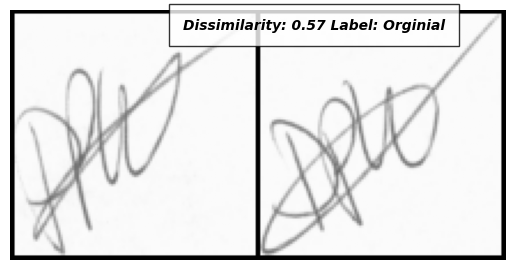

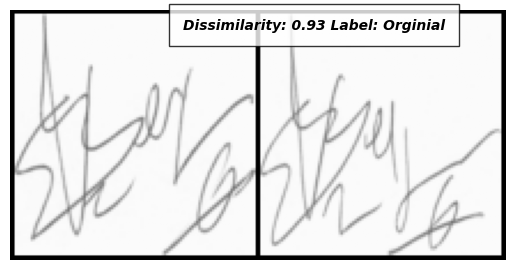

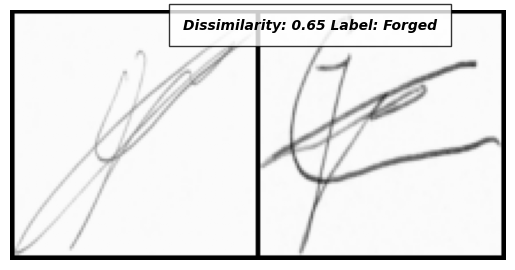

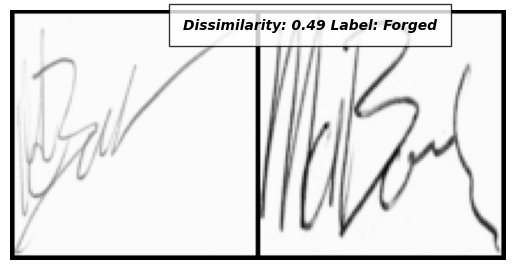

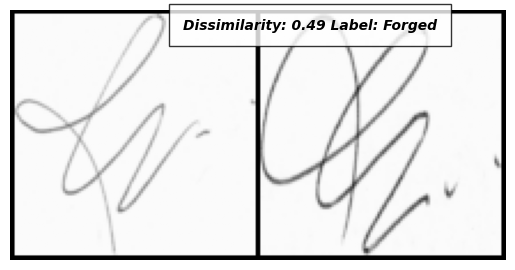

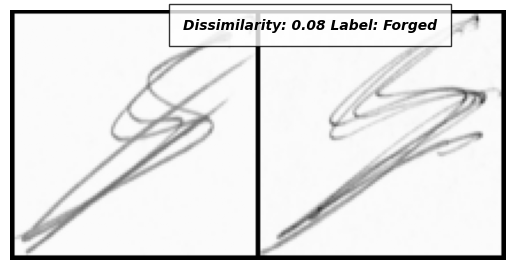

In [ ]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0):
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

Similarity between the two signatures: 41.96%
The signature is Forgery.


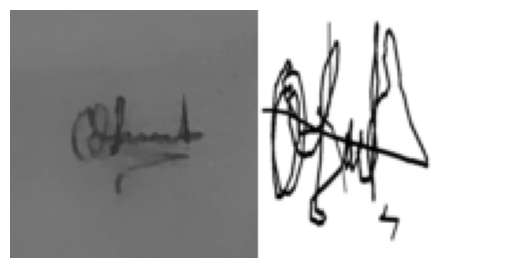

In [ ]:
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF


# İki imza görüntüsünü yükleyin ve dönüşümleri uygulayın
image_path1 = "/content/6..jpg"
image_path2 = "/content/4..jpeg"

img1 = Image.open(image_path1)
img2 = Image.open(image_path2)

img1 = img1.convert("L")
img2 = img2.convert("L")

transform = transforms.Compose([transforms.Resize((105, 105)), transforms.ToTensor()])
img1 = transform(img1).unsqueeze(0).to(device)  # Giriş verisini GPU'ya gönder
img2 = transform(img2).unsqueeze(0).to(device)  # Giriş verisini GPU'ya gönder

# İki imza görüntüsünü modele gönderin
output1, output2 = model(img1, img2)

# İki imza arasındaki benzerlik derecesini hesaplayın
eucledian_distance = F.pairwise_distance(output1, output2)

# Benzerlik derecesini yüzde olarak hesaplayın
similarity_percentage = (1 - eucledian_distance.item()) * 100

# Benzerlik yüzdesini ve sonucu yazdırın
print("Similarity between the two signatures: {:.2f}%".format(similarity_percentage))
if similarity_percentage >= threshold_percentage:
    print("The signature is Original.")
else:
    print("The signature is Forgery.")

# İmza görüntülerini PIL formatına dönüştürün
img1_pil = TF.to_pil_image(img1.squeeze(0).cpu())  # GPU'dan çıkartıp PIL formatına dönüştürün
img2_pil = TF.to_pil_image(img2.squeeze(0).cpu())  # GPU'dan çıkartıp PIL formatına dönüştürün

# İki imza görüntüsünü yan yana birleştirin
concatenated_img = Image.new("L", (img1_pil.width + img2_pil.width, img1_pil.height))
concatenated_img.paste(img1_pil, (0, 0))
concatenated_img.paste(img2_pil, (img1_pil.width, 0))

# İki imza görüntüsünü gösterin
plt.imshow(concatenated_img, cmap='gray')
plt.axis("off")
plt.show()

# İki imza görüntüsünü kaydedin
concatenated_img.save("/content/sonu3.jpg")
